In [1]:
import numpy as np
import pymc3 as pm

import pandas as pd
from scipy.special import logit, expit

import matplotlib.pyplot as plt

from statsmodels.stats.proportion import proportion_confint
from pygam import s, GAM
import altair as alt

In [2]:
scores = np.concatenate([np.load(f'../processed_data/D4_all{i}.npy') for i in range(12)])

In [3]:
df = pd.read_csv('../data/41586_2019_917_MOESM4_ESM.csv')

In [4]:
#these are the docking scores:
df['Energy'] = np.array(df['Energy'].str.strip('¶')).astype(float)

#set the "not determined" records to zero inhibition:
df.loc[df['Inhibition (%) at 10uM'].str.contains('ND'), 'Inhibition (%) at 10uM'] = 0


In [5]:
ranks = (np.concatenate([scores, df['Energy']]).argsort().argsort()+1)

In [ ]:
# normalized_ranks = ( (np.concatenate([scores, df['Energy']]).argsort().argsort()+1) /\
#                 ((scores.shape[0]+df['Energy'].shape[0]) - 1) )


In [6]:
normalized_ranks = ranks / ((scores.shape[0]+df['Energy'].shape[0]))

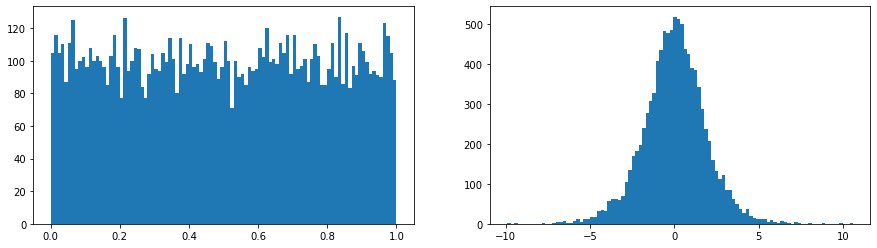

In [7]:
#we can see that the logit(normalized_ranks) are normally distrubuted, 
#which is what you would expect when logit-transforming a uniformly-distributed

fig, ax = plt.subplots(1,2)
fig.set_figwidth(15)

_ = ax[0].hist(np.random.choice(normalized_ranks, 10000), bins=100)
_ = ax[1].hist(logit(np.random.choice(normalized_ranks, 10000)), bins=100)

In [8]:
#this holds the ranks of the in vitro tested molecules:
ranks = normalized_ranks[-df['Energy'].shape[0]:]
hits = df['Inhibition (%) at 10uM'].values.astype(float)>50


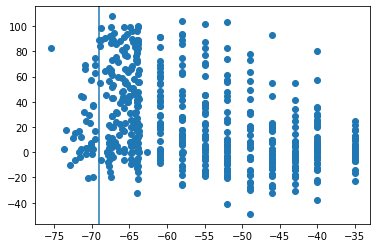

In [9]:
plt.scatter(df['Energy'], df['Inhibition (%) at 10uM'].values.astype(float))
plt.axvline(-69)

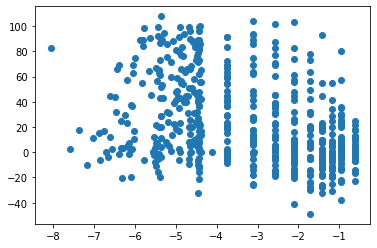

In [11]:
#observe that this resembles Lyu et al, except the points at the bottom of the 
#curve are bunched a bit closer. This more accurately represents
#where the tested range sits in comparison to the rest of the distribution.


plt.scatter(np.log10(ranks), df['Inhibition (%) at 10uM'].values.astype(float))

In [19]:
from pygam import s, GAM

#gam = LinearGAM(s(0, n_splines=8,)).fit(np.log10(ranks)[:,None],  hits.astype(int))
gam = GAM(s(0, n_splines=10,), 
          distribution='binomial',
          link='logit',
          #distribution='normal',
          #link='log',
         ).fit(np.log10(ranks)[:,None],  
               hits.astype(int))


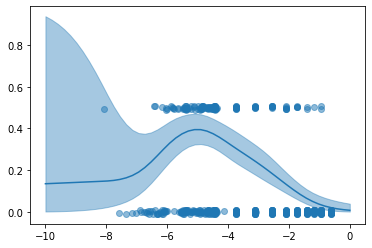

In [20]:
x = np.linspace(-10, 0)[:,None]
plt.plot(x, gam.predict(x))
plt.scatter(np.log10(ranks), 
            (df['Inhibition (%) at 10uM'].values.astype(float)>50) / 2 + \
            np.random.uniform(-0.01, 0.01, len(ranks)),
           alpha=0.5)
plt.fill_between(x.ravel(), *gam.confidence_intervals(x).T, alpha=0.4, color='C0')

12


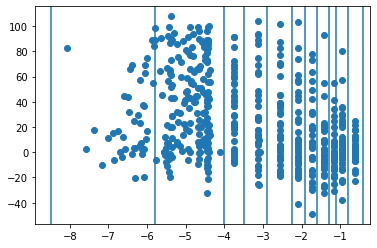

In [21]:
plt.scatter(np.log10(ranks), df['Inhibition (%) at 10uM'].values.astype(float))
bins = [-8.5, -5.8, -4, -3.5, -2.9, -2.25, -1.9, -1.6, -1.3, -1.1, -0.8, -.4]
print(len(bins))
for b in bins:
    plt.axvline(b)

In [22]:
idx = np.digitize(np.log10(ranks), bins)


df_prop = pd.DataFrame(columns=['x', 'y', 'y1', 'y2'])
for i in range(1, idx.max()+1):
    samples = hits[idx==i]
    propci = proportion_confint(samples.sum(), nobs=len(samples), method='jeffreys')
    print(samples.mean(), propci)
    df_prop.loc[i-1] = [100*10**((bins[i-1]+bins[i])/2), samples.mean(), propci[0], propci[1]]

0.2619047619047619 (0.1478425384913987, 0.407508371484117)
0.37777777777777777 (0.309354714247769, 0.4500960307646984)
0.3157894736842105 (0.1856138501203135, 0.4728433710422403)
0.23684210526315788 (0.12415617766169264, 0.38788297874502586)
0.175 (0.08185393408002506, 0.31317231261408185)
0.15789473684210525 (0.0687035882721138, 0.2968271998403339)
0.1111111111111111 (0.03868714601646236, 0.2428730120234911)
0.05714285714285714 (0.012063652129890362, 0.17091684882105385)
0.027777777777777776 (0.0030136938252919216, 0.12257359234796428)
0.05714285714285714 (0.012063652129890362, 0.17091684882105385)
0.0 (1.3929610979532534e-05, 0.06877653611605908)


In [23]:
base = alt.Chart(df_prop).transform_calculate(

)

# generate the points
points = base.mark_point(
    filled=True,
    size=50,
    color='black'
).encode(
    x=alt.X('x', scale=alt.Scale(type='log')),
    y=alt.Y('y', title='In vitro hit rate'),
)

# generate the error bars
errorbars = base.mark_errorbar().encode(
    x=alt.X("x",scale=alt.Scale(type='log')),
    y=alt.Y('y1:Q',title='In vitro hit rate'),
    y2="y2:Q"
)

In [24]:
x = np.linspace(-8, -.25)[:,None]
df_ = pd.DataFrame({'x':10**x.ravel()*100, 
                   'y':gam.predict(x), 
                  'y1':gam.confidence_intervals(x).T[0],
                 'y2':gam.confidence_intervals(x).T[1]})

ch = alt.Chart(df_).mark_line(opacity=0.4).encode(
    x=alt.X('x:Q', title='Percentile docking score', scale=alt.Scale(type='log')),
    y=alt.Y('y:Q', title='In vitro hit rate'),
)


ci = alt.Chart(df_).mark_area(opacity=0.3).encode(
    x=alt.X('x:Q', scale=alt.Scale(type='log')),
    y=alt.Y('y1:Q',title='In vitro hit rate'),
    y2='y2:Q'
)


In [25]:
points+errorbars+ch+ci

alt.LayerChart(...)

In [109]:
normalized_ranks = ( (np.concatenate([scores, df['Energy']]).argsort().argsort()+1) /\
                ((scores.shape[0]+df['Energy'].shape[0]) - 1) )

In [110]:
#this holds the ranks of the in vitro tested molecules:
ranks = normalized_ranks[-df['Energy'].shape[0]:]
hits = df['Inhibition (%) at 10uM'].values.astype(float)>50

12


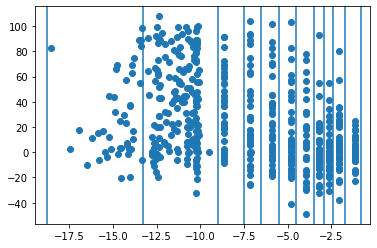

In [26]:
plt.scatter(logit(ranks), df['Inhibition (%) at 10uM'].values.astype(float))
bins = np.array([-18.8, -13.3, -9, -7.5, -6.5, -5.5, -4.5, -3.5, -2.9, -2.4, -1.7, -0.8,])
print(len(bins))
for b in bins:
    plt.axvline(b)

In [27]:
idx = np.digitize(logit(ranks), bins)


df_prop = pd.DataFrame(columns=['x', 'y', 'y1', 'y2'])
for i in range(1, idx.max()+1):
    samples = hits[idx==i]
    propci = proportion_confint(samples.sum(), nobs=len(samples), method='jeffreys')
    print(samples.mean(), propci)
    df_prop.loc[i-1] = [100*expit((bins[i-1]+bins[i])/2), samples.mean(), propci[0], propci[1]]
    

0.2727272727272727 (0.1585602290773268, 0.41568899787741154)
0.37640449438202245 (0.3076865633757363, 0.44910522866970504)
0.3157894736842105 (0.1856138501203135, 0.4728433710422403)
0.23684210526315788 (0.12415617766169264, 0.38788297874502586)
0.175 (0.08185393408002506, 0.31317231261408185)
0.15789473684210525 (0.0687035882721138, 0.2968271998403339)
0.1111111111111111 (0.03868714601646236, 0.2428730120234911)
0.05714285714285714 (0.012063652129890362, 0.17091684882105385)
0.027777777777777776 (0.0030136938252919216, 0.12257359234796428)
0.05714285714285714 (0.012063652129890362, 0.17091684882105385)
0.0 (1.3929610979532534e-05, 0.06877653611605908)


In [28]:
base = alt.Chart(df_prop).transform_calculate(

)

# generate the points
points = base.mark_point(
    filled=True,
    size=50,
    color='black'
).encode(
    x=alt.X('x', scale=alt.Scale(type='log')),
    y=alt.Y('y', title='In vitro hit rate'),
)

# generate the error bars
errorbars = base.mark_errorbar().encode(
    x=alt.X("x",scale=alt.Scale(type='log')),
    y=alt.Y('y1:Q',title='In vitro hit rate'),
    y2="y2:Q"
)

In [45]:

gam = GAM(s(0, n_splines=8,), 
          distribution='binomial',
          link='logit',
          #distribution='normal',
          #link='log',
         ).fit(logit(ranks)[:,None],  
               hits.astype(int))


In [46]:
x = np.linspace(-20, 10)[:,None]
df_ = pd.DataFrame({'x':expit(x.ravel())*100, 
                   'y':gam.predict(x), 
                  'y1':gam.confidence_intervals(x).T[0],
                 'y2':gam.confidence_intervals(x).T[1]})

ch = alt.Chart(df_).mark_line(opacity=0.4).encode(
    x=alt.X('x:Q', title='Percentile docking score', scale=alt.Scale(type='log')),
    y=alt.Y('y:Q', title='In vitro hit rate'),
)


ci = alt.Chart(df_).mark_area(opacity=0.3).encode(
    x=alt.X('x:Q', scale=alt.Scale(type='log')),
    y=alt.Y('y1:Q',title='In vitro hit rate'),
    y2='y2:Q'
)


In [47]:
points+errorbars+ch+ci

alt.LayerChart(...)

In [44]:
(points+errorbars+ch+ci).save('../figures/hit_rate_vs_rank.html')

In [99]:
x = np.linspace(-20, -1)[:,None]
rate = gam.predict(x)
percentiles = expit(x.ravel())*100
n = percentiles /100 * 116*1e6

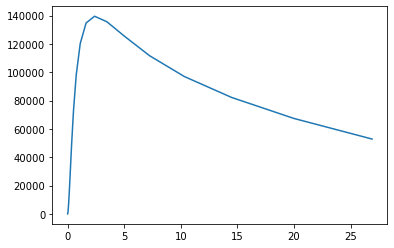

In [100]:
plt.plot(percentiles[1:], np.diff(percentiles/100 * 116*1e6) * rate[1:])